<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/PFLD/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random
import tensorflow_addons as tfa

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Add your name and filepath to the project folder so that you can load the datasets.


In [3]:
USER = "John"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]
DATASETS_PATH = os.path.join(PROJECT_FILEPATH, "datasets", "300W-3D")

## Data Preparation

In [4]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [167]:
import tensorflow as tf

DATALOADER_BASE_PATH = PROJECT_FILEPATH + "/datasets/tf-datasets"

class DataLoader:

  IMAGE_SHAPE = (450, 450, 3)
  LANDMARKS_SHAPE = (136,)

  BATCH_SIZE = 16
  TRAIN_PATHS = [f"{DATALOADER_BASE_PATH}/large-train-{i}.tfrecord.gz" for i in range(8)]
  VAL_PATHS = [f"{DATALOADER_BASE_PATH}/large-val-{i}.tfrecord.gz" for i in range(8)]
  TEST_PATHS = [f"{DATALOADER_BASE_PATH}/large-test-{i}.tfrecord.gz" for i in range(8)]

  def load_datasets():
    dl = DataLoader()
    return (dl.__load_dataset(DataLoader.TRAIN_PATHS, DataLoader.BATCH_SIZE, 'train.h5'),
            dl.__load_dataset(DataLoader.VAL_PATHS, DataLoader.BATCH_SIZE, 'val.h5'),
            dl.__load_dataset(DataLoader.TEST_PATHS, 1, 'test.h5'))

  def __load_dataset(self, filepath, batch_size, cache_path):
    dataset = tf.data.TFRecordDataset([filepath], compression_type="GZIP")
    dataset = dataset.map(self.__parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(self.__reshape_entry, num_parallel_calls=tf.data.AUTOTUNE)
    images = dataset.map(lambda x,y: x).batch(batch_size)
    landmarks = dataset.map(lambda x,y: y['landmarks']).batch(batch_size)
    poses = dataset.map(lambda x,y: y['pose']).batch(batch_size)

    dataset = tf.data.Dataset.zip((poses, landmarks)).map(lambda x,y: {'pose': x, 'landmarks': y})
    dataset = tf.data.Dataset.zip((images, dataset))
    dataset = dataset.cache(cache_path)

    return dataset


  def __parse_example(self, record):
    feature_names = {}
    feature_names['image'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['landmarks'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['pose'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    return tf.io.parse_single_example(record, feature_names)

  def __reshape_entry(self, entry):
    image = tf.reshape(entry['image'], DataLoader.IMAGE_SHAPE)
    landmarks = tf.reshape(entry['landmarks'], DataLoader.LANDMARKS_SHAPE)
    pose = entry['pose']
    return image, {"pose": pose, "landmarks": landmarks}

ds, val_ds, test_ds = DataLoader.load_datasets()

for record in ds.take(2):
  print(record[1]["pose"])

tf.Tensor(
[[-0.43859825 -0.16568494  0.38924468]
 [-0.03748168  0.51908076 -0.11684202]
 [-0.18769237  0.6844929  -0.45596245]
 [-0.1300456   0.41874716 -0.07646893]
 [ 0.07986775  0.29589358  0.01229366]
 [ 0.1913057   0.5760248   0.05293354]
 [ 0.26961446 -0.72917545 -0.11107972]
 [-0.34974042  0.4995206  -0.24593015]
 [-0.21273568  0.6022028  -0.11824094]
 [-0.4470286   0.03732983 -0.32026705]
 [-0.06540844  0.64562225 -0.0886282 ]
 [-0.41258425  0.40329474 -0.20874652]
 [-0.44301987  0.6705256  -0.5691878 ]
 [ 0.51052636 -0.43001994 -0.11474944]
 [-0.06953607 -0.5917024  -0.1767619 ]
 [ 0.23389895  0.541639   -0.06933594]], shape=(16, 3), dtype=float32)
tf.Tensor(
[[-0.20576854 -0.5255532   0.48411405]
 [-0.21938275  0.7863171  -0.45038894]
 [ 0.00782996 -0.61663395  0.34466776]
 [-0.4473182   0.36553824 -0.0617262 ]
 [-0.01619064 -0.53246003  0.00155187]
 [-0.4841348   0.06029027 -0.3412877 ]
 [-0.00771102 -0.6509855  -0.22129938]
 [ 0.44911247 -0.65629536 -0.64747614]
 [-0.11226

## Data Augmentation

In [171]:
def rand_translation(imgs, labels):
  batch_size = 16
  translations = np.random.uniform(low=-50, high=50,size=(batch_size,2)).astype("float32")
  imgs = tfa.image.translate(imgs, translations, fill_mode="reflect")
  landmark_translations = translations.repeat(68, axis=0).reshape(batch_size, 136) / 450.0
  labels["landmarks"] += landmark_translations
  return (imgs, labels)

mp_ds = ds.map(rand_translation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


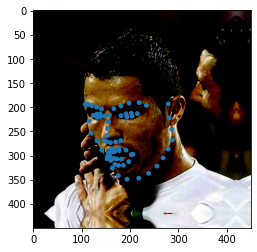

In [153]:
#@title View Predicted Images
image_index = 7 #@param {type:"slider", min:1, max:16, step:1}
i = 0
done = False
for batch in mp_ds.take(16):

  for img, landmarks in zip(batch[0], batch[1]["landmarks"]):
    if (i == image_index):
      display_landmarks(img.numpy(), landmarks.numpy() * 450)
      done = True
      break
    i += 1
  if done:
    break

In [156]:
for record in ds.map(rand_translation):
  pass

(None, 450, 450, 3)


InvalidArgumentError: ignored

## [PFLD Model](https://arxiv.org/pdf/1902.10859.pdf)


In [139]:

def relu6(x):
  return tf.clip_by_value(x, 0, 6)

def mobilenet_block(x:layers.Layer, t=2, c=64, s=2):
  """
  MoblieNetv2 residual block
  Arguments
  -----------
    x: keras layer input
    t: expansion factor based on size of input layer
    c: number of input channels
    s: stride width/height
  """
  in_channels = x.shape[-1]
  if in_channels != c:
    x = layers.Conv2D(c, (1,1), strides=(1,1), padding="same")(x) 
  l = layers.Conv2D(c * t, (1,1), strides=(1,1), padding="same")(x) 
  l = layers.Activation(relu6)(l)
  l = layers.BatchNormalization()(l)
  l = layers.DepthwiseConv2D((s,s), padding="same")(l)
  l = layers.Activation(relu6)(l)
  l = layers.BatchNormalization()(l)
  l = layers.Conv2D(c, (1,1), strides=(1,1), padding="same")(l)
  return layers.Add()([l,x])

def create_PFLD_model(input_shape, training=True):
  """
  Builds a backbone model that takes in an image and outputs 68 landmark locations.
  If training is true, it attaches the aux model
  """
  input_layer = layers.Input(input_shape, name="model_input")
  x = layers.Conv2D(32,(3,3), strides=(2,2), activation="relu", padding="same")(input_layer)
  x = layers.DepthwiseConv2D(32, strides=(1,1), activation="relu")(x)
  for _ in range(5):
    x = mobilenet_block(x, t=2, c=16, s=2)
  aux_in = mobilenet_block(x, t=2, c=32, s=2)
  aux_out = create_aux_model(aux_in)
  x = aux_in
  for _ in range(6):
    x = mobilenet_block(x, t=3, c=32, s=2)
  x = mobilenet_block(x, t=2, c=8, s=2) 

  x = layers.Conv2D(16,(3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(16,(7,7), strides=(4,4), activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(136, activation="relu", name="landmarks")(x)
  PFLD =  Model(name="PFLM_Backbone", inputs=input_layer, outputs=[x, aux_out])
  return PFLD
  
  


def create_aux_model(input_layer: layers.Layer):
  """
  Auxiliary model takes in the latent image representation from the MobileNet
  layers and produces an estimate of the pitch, yaw and roll of the face
  """

  x = input_layer
  x = layers.Conv2D(128, (3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(128, (3,3), strides=(1,1), activation="relu")(x)
  x = layers.Conv2D(32, (3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(128, (7,7), strides=(1,1), activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(32, activation="relu")(x)
  return layers.Dense(3, activation="relu", name="pose")(x)






In [140]:
opt = tf.keras.optimizers.Adam()
model = create_PFLD_model((450,450,3))

model.compile(optimizer=opt, loss={"landmarks": "mse", "pose": "mse"}, metrics={"landmarks": tf.keras.metrics.RootMeanSquaredError(), "pose": tf.keras.metrics.RootMeanSquaredError()})
model.summary()

Model: "PFLM_Backbone"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 450, 450, 3) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 225, 225, 32) 896         model_input[0][0]                
__________________________________________________________________________________________________
depthwise_conv2d_28 (DepthwiseC (None, 194, 194, 32) 32800       conv2d_72[0][0]                  
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 194, 194, 16) 528         depthwise_conv2d_28[0][0]        
______________________________________________________________________________________

In [145]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
save_path = os.path.join(PROJECT_FILEPATH, "models", "PFLDv3.h5")
SHOULD_TRAIN = True
if SHOULD_TRAIN:
  early_stop = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5)
  cp_filepath = os.path.join(PROJECT_FILEPATH, "models", "PFLD_Checkpoints")
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, save_best_only=True)
  model.fit(ds, epochs=50, validation_data=val_ds, callbacks = [checkpoint, early_stop])
  model.save(save_path)
else:
  model_path = os.path.join(PROJECT_FILEPATH, "models", "PFLD.h5")
  model = load_model(model_path, custom_objects={"relu6": relu6})

Epoch 1/50
    162/Unknown - 364s 2s/step - loss: 0.1038 - landmarks_loss: 0.0547 - pose_loss: 0.0492 - landmarks_root_mean_squared_error: 0.2339 - pose_root_mean_squared_error: 0.2217

InvalidArgumentError: ignored

In [10]:
model.evaluate(test_ds, return_dict=True)

875/875 [==============================] - 22s 25ms/step - loss: 0.0471 - landmarks_loss: 0.0021 - pose_loss: 0.0450 - landmarks_root_mean_squared_error: 0.0459 - pose_root_mean_squared_error: 0.2121


{'landmarks_loss': 0.00210752384737134,
 'landmarks_root_mean_squared_error': 0.04590778052806854,
 'loss': 0.04707809165120125,
 'pose_loss': 0.044970616698265076,
 'pose_root_mean_squared_error': 0.2120627909898758}

In [12]:
# pd.DataFrame(model.history.history).plot()
images = test_ds.take(16).map(lambda x,y : x)
landmarks, poses = model.predict(images)
landmarks = landmarks *450

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


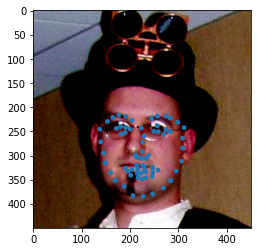

In [18]:
#@title View Predicted Images
image_index = 2 #@param {type:"slider", min:1, max:16, step:1}
points = landmarks * 450
i = 0
done = False
for batch in images:
  for img in batch:
    if (i == image_index):
      
      display_landmarks(tf.reshape(img, (450,450,3)), landmarks[image_index])
      done = True
      break
    i += 1
  if done:
    break